# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
from scipy.stats import randint
from sklearn.feature_selection import SelectKBest, chi2
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler
from IPython.display import HTML


In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
y = df['y']
y.value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
# 1. Drop 'duration' feature
df = df.drop('duration', axis=1)

In [7]:
# 2. Handle 'unknown' values (replace with mode)
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    df[col] = df[col].replace('unknown', df[col].mode()[0])

In [8]:
# 3. One-hot encode categorical features
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
encoded_features = onehot_encoder.fit_transform(df[categorical_cols]).toarray()

# Get the correct column names
column_names = onehot_encoder.get_feature_names(categorical_cols)

# Create new columns for encoded features
encoded_df = pd.DataFrame(encoded_features, columns=column_names)

# Concatenate encoded features with the original DataFrame
df = pd.concat([df, encoded_df], axis=1)
df = df.drop(categorical_cols, axis=1)

In [9]:
# 4. Encode 'y' using LabelEncoder
label_encoder = LabelEncoder()
df['y'] = label_encoder.fit_transform(df['y'])

In [10]:
# Print the preprocessed DataFrame
print(df.head())

   age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56         1    999         0           1.1          93.994   
1   57         1    999         0           1.1          93.994   
2   37         1    999         0           1.1          93.994   
3   40         1    999         0           1.1          93.994   
4   56         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  y  ...  month_oct  month_sep  \
0          -36.4      4.857       5191.0  0  ...        0.0        0.0   
1          -36.4      4.857       5191.0  0  ...        0.0        0.0   
2          -36.4      4.857       5191.0  0  ...        0.0        0.0   
3          -36.4      4.857       5191.0  0  ...        0.0        0.0   
4          -36.4      4.857       5191.0  0  ...        0.0        0.0   

   day_of_week_fri  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0              0.0              1.0              0.0              0.0   
1     

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [11]:
# Split data
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [12]:
# Given that the yes/no value are lopsided heavily towards no, we can use a dumb baseline

baseline_accuracy = y.value_counts()[0] / len(y)
print(f"Dumb Baseline Accuracy: {baseline_accuracy:.2%}")

Dumb Baseline Accuracy: 88.73%


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [13]:
# Create and train the LogisticRegression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

### Problem 9: Score the Model

What is the accuracy of your model?

In [48]:
# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)
#baseline_accuracy = f1_score(y_test, y_pred)

print(f"Logistic Regression Baseline Accuracy Score: {baseline_accuracy:.2%}")

ValueError: X has 51 features per sample; expecting 56

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [34]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC()
}

results = []

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    results.append([model_name, train_time, train_accuracy, test_accuracy])

base_model_comparison_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Score', 'Test Score'])
base_model_comparison_df

/Users/vinayjain/Library/CloudStorage/GoogleDrive-vinay@morningviewtech.com/My Drive/Berkeley/assignments/classifier_performance/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Train Time,Train Score,Test Score
0,Logistic Regression,0.247450,0.900607,0.896698
1,KNN,0.001003,0.911290,0.884681
2,Decision Tree,0.120569,0.994112,0.846686
3,SVM,23.723691,0.901032,0.897669


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### The 'y' values are quite lopsided in favor of 'no'. 
Close to 89% are the value of 'no' (or 0). 
The performance metric evaluation will need to be adjusted accordingly to using F1 score.

In [29]:


# Load the data
df = pd.read_csv('data/bank-additional-full.csv', sep=';')

# 1. Drop 'duration' feature
df = df.drop('duration', axis=1)
# df = df.drop(['day_of_week', 'month'], axis=1)
df = df.drop(['day_of_week'], axis=1) #drop day_of_week

# For 'poutcome', if the value is 'nonexistent', then change it to 'failure' if 'pdays' is not 999.
def change_poutcome(row):
    if row['poutcome'] == 'nonexistent' and row['pdays'] != 999:
        return 'failure'
    return row['poutcome']
df['poutcome'] = df.apply(change_poutcome, axis=1)

# Handle 999 in 'pdays' since it signifies that the client was not previously contacted
# Replace 999 with NaN followed by replacing NaN with the mean
df['pdays'] = df['pdays'].replace(999, np.nan)
df['pdays'] = df['pdays'].fillna(df['pdays'].mean())


# 2. Handle 'unknown' values (replace with mode)
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    df[col] = df[col].replace('unknown', df[col].mode()[0])

# 3. One-hot encode categorical features
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month'] #'day_of_week', 
encoded_features = onehot_encoder.fit_transform(df[categorical_cols]).toarray()

# Get the correct column names
# column_names = onehot_encoder.get_feature_names_out(categorical_cols)
column_names = onehot_encoder.get_feature_names(categorical_cols)

# Create new columns for encoded features
encoded_df = pd.DataFrame(encoded_features, columns=column_names)

# Concatenate encoded features with the original DataFrame
df = pd.concat([df, encoded_df], axis=1)
df = df.drop(categorical_cols, axis=1)

# 4. Encode 'y' using LabelEncoder
label_encoder = LabelEncoder()
df['y'] = label_encoder.fit_transform(df['y'])

# 5. Split into features and target
X = df.drop('y', axis=1)
y = df['y']

# 6. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Scale numerical features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 8. Feature Selection (using SelectKBest) to reduce dimensionality
selector = SelectKBest(chi2, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]


# Define models and their hyperparameter distributions
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=10000, penalty='l2'),
        'param_distributions': {'C': [1.06, 1.065, 1.07]}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_distributions': {
            'p': [1, 2],
            'n_neighbors': [3, 4, 5],
            'algorithm': ['auto', 'ball_tree', 'brute', 'kd_tree'],
            'leaf_size': [95, 100, 105]
            }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(), #class_weight='balanced'
        'param_distributions': {
            'min_samples_split': [65, 70, 75],
            'min_samples_leaf': [9, 10, 11],
            'max_depth': [4, 5, 6]
        }
    },
    'SVM (Linear)': {
        'model': LinearSVC(dual=False, max_iter=10000),
        'param_distributions': {'C': [2, 3, 4]}
    },
    'SVM (Poly)': {
        'model': SVC(kernel='poly'),
        'param_distributions': {'degree': [2, 3, 4], 'C': [8, 9, 10]}
    },
    'SVM (RBF)': {
        'model': SVC(kernel='rbf'),
        'param_distributions': {'gamma': ['scale', 'auto'], 'C': [5, 6, 7]}
    },
    'SVM (Sigmoid)': {
        'model': SVC(kernel='sigmoid'),
        'param_distributions': {'gamma': ['scale', 'auto'], 'C': [0.1, 0.2, 0.3]}
    }
}

results = []
pd.set_option('display.max_colwidth', None)  # Set to None for unlimited width

for model_name, model_params in models.items():
    model = model_params['model']
    param_distributions = model_params['param_distributions']

    # RandomizedSearchCV with Cross-Validation (using 'accuracy' for imbalanced data)
    random_search = RandomizedSearchCV(model, param_distributions, cv=3, scoring='accuracy', n_jobs=-1, random_state=42, n_iter=3)
    random_search.fit(X_train_selected, y_train)

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    start_time = time.time()
    best_model.fit(X_train_selected, y_train)
    train_time = time.time() - start_time

    y_pred_train = best_model.predict(X_train_selected)
    train_score = accuracy_score(y_train, y_pred_train)

    y_pred_test = best_model.predict(X_test_selected)
    test_score = accuracy_score(y_test, y_pred_test)

    # Format best_params for printing
    formatted_params = ", ".join(f"{key}: {value}" for key, value in best_params.items())

    # Calculate feature importances
    if model_name == 'Decision Tree':
        feature_importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns[selector.get_support()], 'Importance': feature_importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        print(f"Feature Importance for {model_name}:\n{feature_importance_df}\n")
    elif model_name == 'Logistic Regression':
        feature_coefficients = best_model.coef_[0]
        feature_coefficient_df = pd.DataFrame({'Feature': X.columns[selector.get_support()], 'Coefficient': feature_coefficients})
        feature_coefficient_df = feature_coefficient_df.sort_values(by='Coefficient', ascending=False)
        print(f"Feature Importance for {model_name}:\n{feature_coefficient_df}\n")
    elif model_name == 'SVM (Linear)':
        perm = PermutationImportance(best_model, random_state=42).fit(X_train_selected, y_train)
        html_weights = eli5.show_weights(perm, feature_names=X.columns[selector.get_support()].tolist())
        print(f"Feature Importance for {model_name}:\n")
        display(html_weights)
        print("\n")
    elif model_name in ['SVM (Poly)', 'SVM (RBF)', 'SVM (Sigmoid)']:
        print(f"Feature Importance for {model_name}: Not directly available for non-linear SVMs.\n")
    elif model_name == 'KNN':
        perm = PermutationImportance(best_model, random_state=42).fit(X_train_selected, y_train)
        #print(f"Feature Importance for {model_name}:\n{eli5.show_weights(perm, feature_names=X.columns[selector.get_support()].tolist(), show=False)}\n")
        html_weights = eli5.show_weights(perm, feature_names=X.columns[selector.get_support()].tolist())
        print(f"Feature Importance for {model_name}:\n")
        display(html_weights)
        print("\n")

    results.append([model_name, train_time, train_score, test_score, formatted_params])
    results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Score', 'Test Score', 'Best Hyperparameters'])
    print(results_df)

results_df

Feature Importance for Logistic Regression:
                        Feature  Coefficient
13             poutcome_success     1.807072
2                cons.price.idx     1.496229
16                    month_mar     1.023291
3                     euribor3m     0.798893
12         poutcome_nonexistent     0.550798
0                      previous     0.484996
6                   job_retired     0.275786
10             contact_cellular     0.275294
7                   job_student     0.231307
15                    month_dec     0.206200
9   education_university.degree     0.105353
18                    month_oct     0.105111
8                marital_single     0.065226
14                    month_apr    -0.062489
19                    month_sep    -0.089932
5               job_blue-collar    -0.114341
11            contact_telephone    -0.273395
17                    month_may    -0.654663
4                   nr.employed    -1.705810
1                  emp.var.rate    -2.603888

          

Weight,Feature
0.0424 ± 0.0024,euribor3m
0.0409 ± 0.0014,cons.price.idx
0.0343 ± 0.0020,emp.var.rate
0.0230 ± 0.0015,month_may
0.0122 ± 0.0014,education_university.degree
0.0120 ± 0.0014,nr.employed
0.0105 ± 0.0004,poutcome_success
0.0100 ± 0.0006,month_apr
0.0092 ± 0.0013,marital_single
0.0078 ± 0.0005,poutcome_nonexistent




                 Model  Train Time  Train Score  Test Score  \
0  Logistic Regression    0.109321     0.899970    0.896577   
1                  KNN    0.391329     0.910288    0.881403   

                                        Best Hyperparameters  
0                                                   C: 1.065  
1  p: 2, n_neighbors: 3, leaf_size: 95, algorithm: ball_tree  
Feature Importance for Decision Tree:
                        Feature  Importance
4                   nr.employed    0.664706
13             poutcome_success    0.128195
14                    month_apr    0.046748
16                    month_mar    0.044270
3                     euribor3m    0.035452
18                    month_oct    0.026354
11            contact_telephone    0.018658
2                cons.price.idx    0.014823
0                      previous    0.010510
9   education_university.degree    0.007886
10             contact_cellular    0.001470
8                marital_single    0.000927
1        

Weight,Feature
0.0265 ± 0.0006,nr.employed
0.0171 ± 0.0002,euribor3m
0.0130 ± 0.0005,poutcome_success
0.0044 ± 0.0008,emp.var.rate
0.0011 ± 0.0003,poutcome_nonexistent
0.0006 ± 0.0004,contact_telephone
0.0005 ± 0.0003,month_mar
0.0004 ± 0.0005,cons.price.idx
0.0001 ± 0.0005,month_may
0.0001 ± 0.0002,marital_single




                 Model  Train Time  Train Score  Test Score  \
0  Logistic Regression    0.109321     0.899970    0.896577   
1                  KNN    0.391329     0.910288    0.881403   
2        Decision Tree    0.016578     0.903460    0.897548   
3         SVM (Linear)    0.047723     0.899970    0.896941   

                                        Best Hyperparameters  
0                                                   C: 1.065  
1  p: 2, n_neighbors: 3, leaf_size: 95, algorithm: ball_tree  
2   min_samples_split: 65, min_samples_leaf: 9, max_depth: 5  
3                                                       C: 2  
Feature Importance for SVM (Poly): Not directly available for non-linear SVMs.

                 Model  Train Time  Train Score  Test Score  \
0  Logistic Regression    0.109321     0.899970    0.896577   
1                  KNN    0.391329     0.910288    0.881403   
2        Decision Tree    0.016578     0.903460    0.897548   
3         SVM (Linear)    0.047723 

,Model,Train Time,Train Score,Test Score,Best Hyperparameters
0,Logistic Regression,0.109321,0.899970,0.896577,C: 1.065
1,KNN,0.391329,0.910288,0.881403,"p: 2, n_neighbors: 3, leaf_size: 95, algorithm: ball_tree"
2,Decision Tree,0.016578,0.903460,0.897548,"min_samples_split: 65, min_samples_leaf: 9, max_depth: 5"
3,SVM (Linear),0.047723,0.899970,0.896941,C: 2
4,SVM (Poly),34.695624,0.904279,0.896698,"degree: 3, C: 8"
5,SVM (RBF),9.064564,0.904401,0.896334,"gamma: scale, C: 5"
6,SVM (Sigmoid),11.295283,0.897936,0.895363,"gamma: auto, C: 0.1"


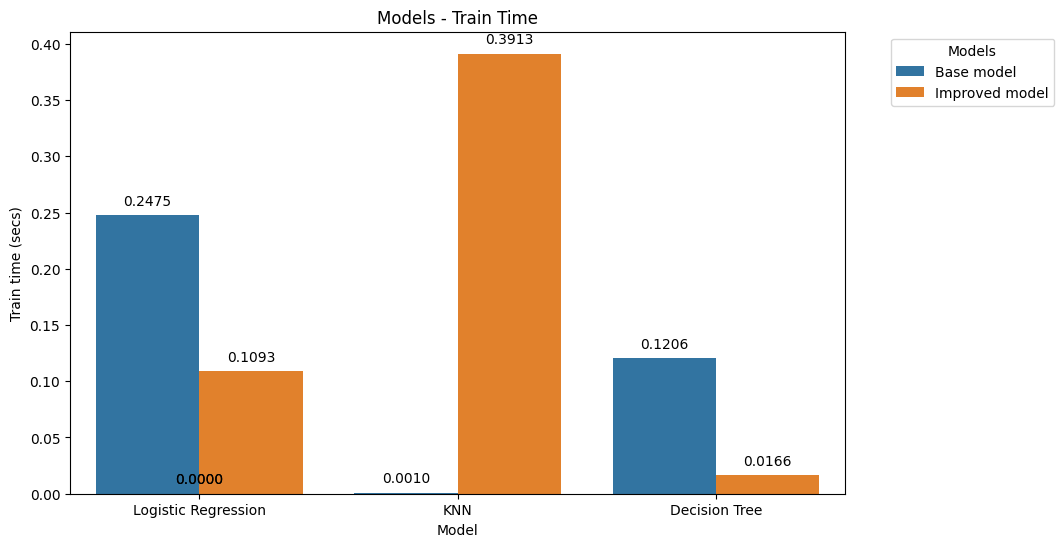

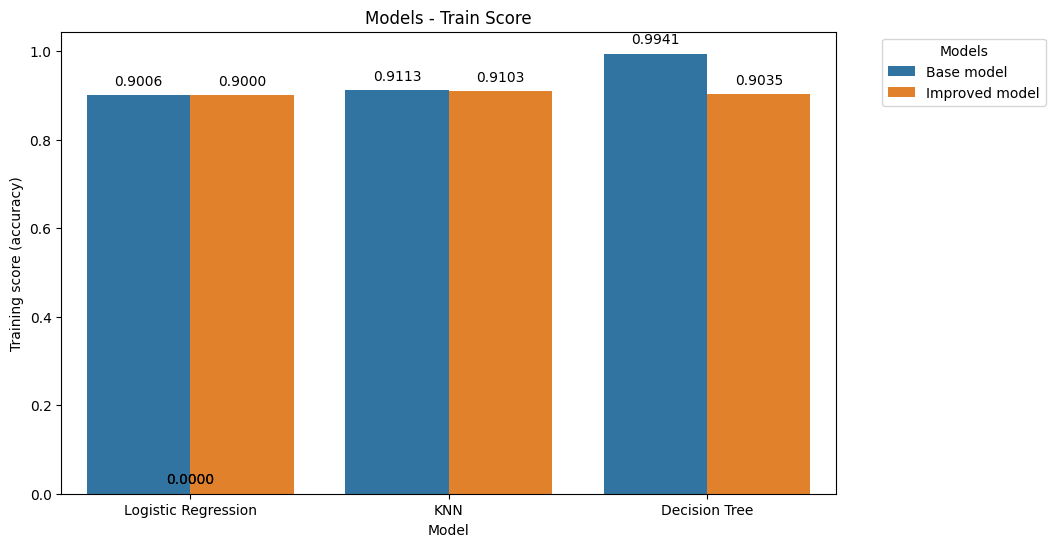

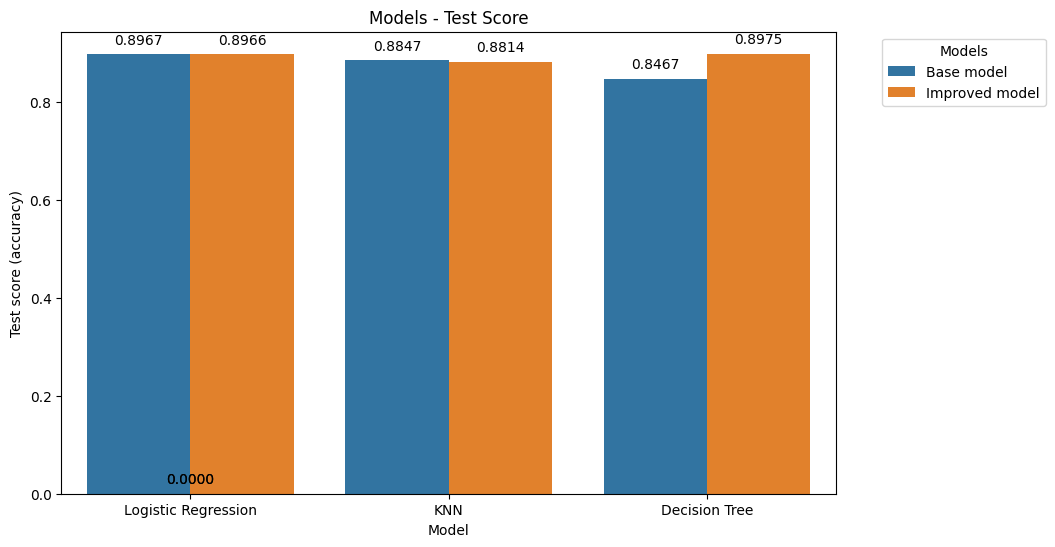

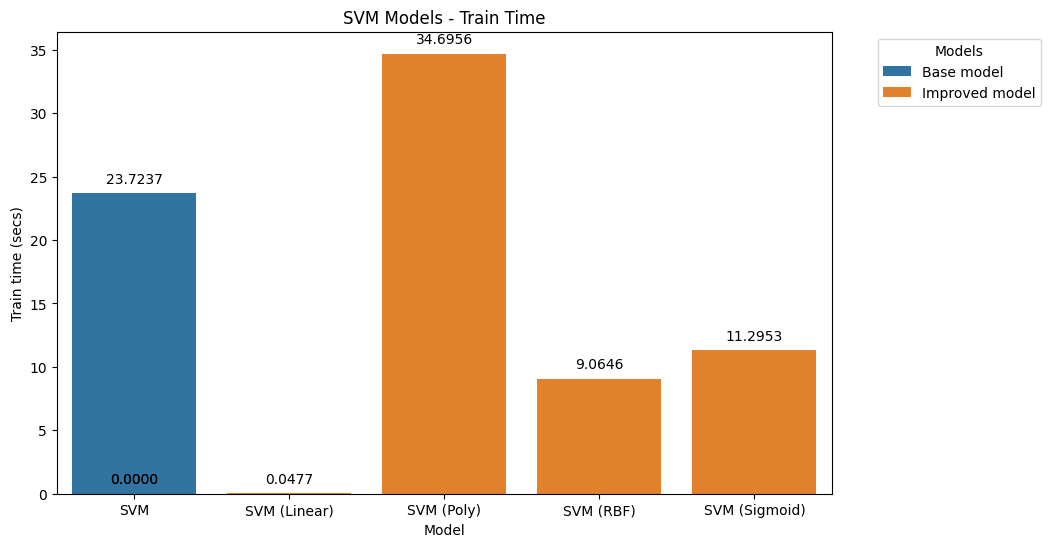

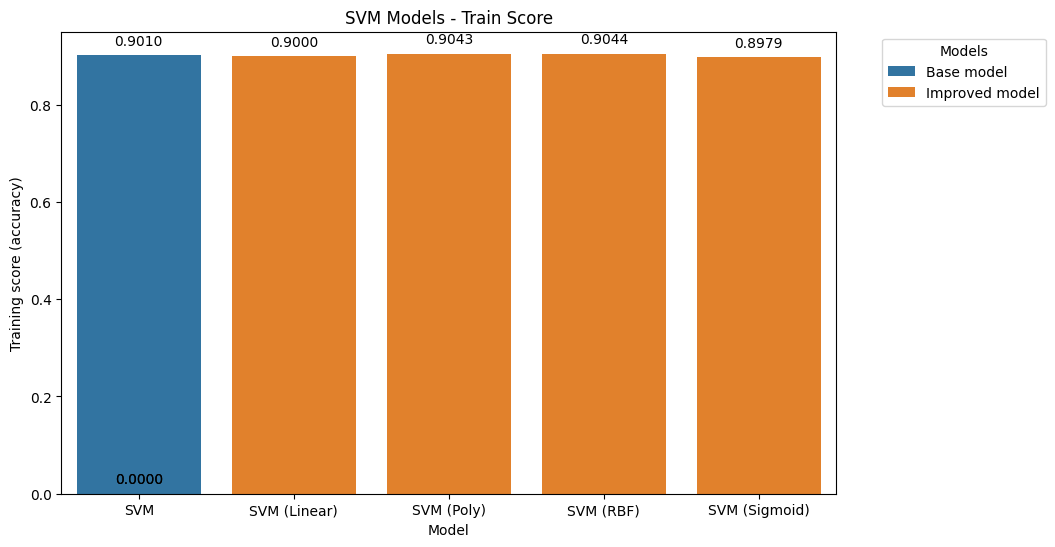

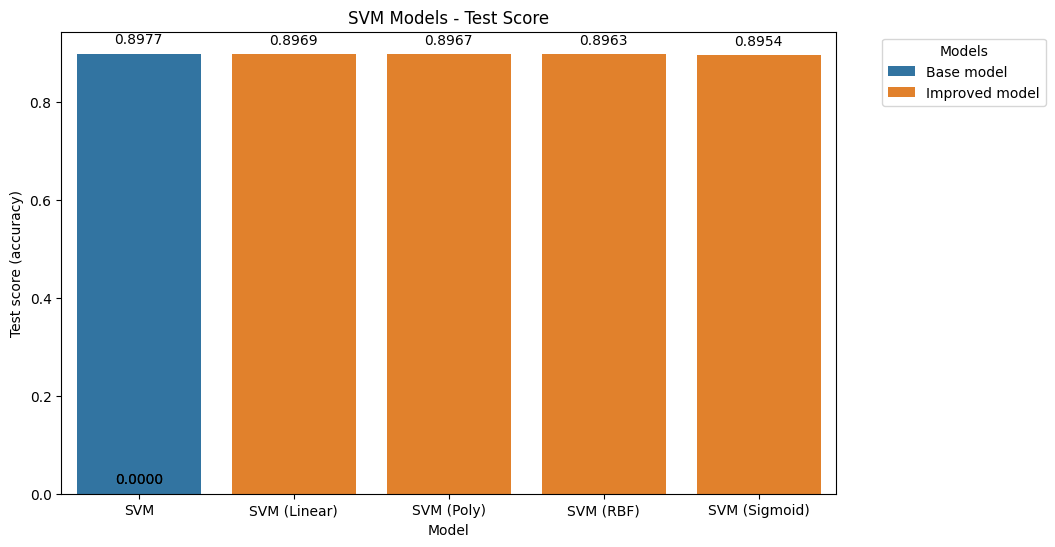

In [47]:
# Update DataFrame column to have more descriptive names
combined_df['DataFrame'] = combined_df['DataFrame'].replace({'base_model_comparison_df': 'Base model', 'results_df': 'Improved model'})

# Create separate dataframes for non-SVM and SVM models
non_svm_df = combined_df[combined_df['Model'].isin(labels)]
svm_df = combined_df[combined_df['Model'].isin(['SVM'] + svm_results_labels)]

# Create plots
for metric, ylabel in zip(['Train Time', 'Train Score', 'Test Score'], ['Train time (secs)', 'Training score (accuracy)', 'Test score (accuracy)']):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=non_svm_df[non_svm_df['variable'] == metric], x='Model', y='value', hue='DataFrame')
    plt.title(f'Models - {metric}')
    plt.ylabel(ylabel)
    plt.xlabel('Model')
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
    plt.show()

for metric, ylabel in zip(['Train Time', 'Train Score', 'Test Score'], ['Train time (secs)', 'Training score (accuracy)', 'Test score (accuracy)']):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=svm_df[svm_df['variable'] == metric], x='Model', y='value', hue='DataFrame')
    plt.title(f'SVM Models - {metric}')
    plt.ylabel(ylabel)
    plt.xlabel('Model')
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
    plt.show()

##### Questions